## **Word Tokenizer exercise**

In this exercise, you are going to build a set of deep learning models on a (sort of) real world task using Tensorflow and Keras. Tensorflow is a deep learning framwork developed by Google, and Keras is a frontend library built on top of Tensorflow (or Theano, CNTK) to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for word tokenization in Thai (แบ่งเว้นวรรคภาษาไทย) using NECTEC's BEST corpus. You will build one model for each of the following type:
- Fully Connected (Feedforward) Neural Network
- One-Dimentional Convolution Neural Network (1D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for keras in this notebook but feel free to modify those parts to suit your needs. You can also complete this exercise using only Tensorflow (without using Keras). Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

**Don't forget to change hardware accelerator to GPU in Google Colab.**


Member: 

Tharnarch Thoranisttakul 63340500025 

Sorapas Weerakul 63340500064

Athimet Aiewcharoen 63340500068

In [1]:
# Run setup code
import warnings
warnings.filterwarnings('ignore')

from modelConfig import ModelBaseConfig, FFNNDOConfig

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.layers import GRU, Conv1D, Embedding, MaxPooling1D, Flatten, TimeDistributed, Reshape, Dropout


from keras.callbacks import ModelCheckpoint, TensorBoard
import math

from keras import backend as K

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix, classification_report

import keras_tuner


%matplotlib inline

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


For simplicity, we are going to build a word tokenization model which is a binary classification model trying to predict whether a character is the begining of the word or not (if it is, then there is a space in front of it) and without using any knowledge about type of character (vowel, number, English character etc.).

For example,

'แมวดำน่ารักมาก' -> 'แมว ดำ น่า รัก มาก'

will have these true labels:

[(แ,1), (ม,0), (ว,0) (ด,1), ( ำ,0), (น,1), (-่,0), (า,0), (ร,1), (-ั,0), (ก,0), (ม,1), (า,0), (ก,0)]

In this task, we will use only main character you are trying to predict  and the characters that surround it (the context) as features. However, you can imagine that a more complex model will try to include more knowledge about each character into the model. You can do that too if you feel like it.

In [2]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}
print(CHARS_MAP)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, '@': 33, 'A': 34, 'B': 35, 'C': 36, 'D': 37, 'E': 38, 'F': 39, 'G': 40, 'H': 41, 'I': 42, 'J': 43, 'K': 44, 'L': 45, 'M': 46, 'N': 47, 'O': 48, 'P': 49, 'Q': 50, 'R': 51, 'S': 52, 'T': 53, 'U': 54, 'V': 55, 'W': 56, 'X': 57, 'Y': 58, 'Z': 59, '[': 60, '\\': 61, ']': 62, '^': 63, '_': 64, 'a': 65, 'b': 66, 'c': 67, 'd': 68, 'e': 69, 'f': 70, 'g': 71, 'h': 72, 'i': 73, 'j': 74, 'k': 75, 'l': 76, 'm': 77, 'n': 78, 'o': 79, 'other': 80, 'p': 81, 'q': 82, 'r': 83, 's': 84, 't': 85, 'u': 86, 'v': 87, 'w': 88, 'x': 89, 'y': 90, 'z': 91, '}': 92, '~': 93, 'ก': 94, 'ข': 95, 'ฃ': 96, 'ค': 97, 'ฅ': 98, 'ฆ': 99, 'ง': 100, 'จ': 101, 'ฉ': 102, 'ช': 103, 'ซ': 104, 'ฌ': 105, 'ญ': 106, 'ฎ': 107, 'ฏ': 108, 'ฐ': 109, 'ฑ'

In [3]:
def create_n_gram_df(df, n_pad):
  """
  Given an input dataframe, create a feature dataframe of shifted characters
  Input:
  df: timeseries of size (N)
  n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used 
    as features for that character.
  
  Output:
  dataframe of size (N * n_pad) which each row contains the character, 
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
  """
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
      df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]

In [4]:
def prepare_feature(best_processed_path, option='train'):
  """
  Transform the path to a directory containing processed files 
  into a feature matrix and output array
  Input:
  best_processed_path: str, path to a processed version of the BEST dataset
  option: str, 'train' or 'test'
  """
  # we use padding equals 21 here to consider 10 characters to the left
  # and 10 characters to the right as features for the character in the middle
  n_pad = 21
  n_pad_2 = int((n_pad - 1)/2)
  pad = [{'char': ' ', 'target': True}]
  df_pad = pd.DataFrame(pad * n_pad_2)

  df = []
  # article types in BEST corpus
  article_types = ['article', 'encyclopedia', 'news', 'novel']
  for article_type in article_types:
      df.append(pd.read_csv(os.path.join(best_processed_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))
  
  df = pd.concat(df)
  # pad with empty string feature
  df = pd.concat((df_pad, df, df_pad))

  # map characters to numbers, use 'other' if not in the predefined character set.
  df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

  # Use nearby characters as features
  df_with_context = create_n_gram_df(df, n_pad=n_pad)

  char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

  # convert pandas dataframe to numpy array to feed to the model
  x_char = df_with_context[char_row].to_numpy()
  y = df_with_context['target'].astype(int).to_numpy()

  return x_char, y

Before running the following commands, we must inform you that our data is quite large and loading the whole dataset at once will **use a lot of memory (~6 GB after processing and up to ~12GB while processing)**. We expect you to be running this on Google Cloud or Google Colab so that you will not run into this problem. But, if, for any reason, you have to run this on your PC or machine with not enough memory, you might need to write a data generator to process a few entries at a time then feed it to the model while training.

For keras, you can use [fit_generator](https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-2-be9ad08f3f0e) to cope with that.

In [5]:
# Path to the preprocessed data
best_processed_path = 'data/corpora/BEST'

In [6]:
# # Load preprocessed BEST corpus
# x_train_char, y_train = prepare_feature(best_processed_path, option='train')
# x_val_char, y_val = prepare_feature(best_processed_path, option='val')
# x_test_char, y_test = prepare_feature(best_processed_path, option='test')

# # As a sanity check, we print out the size of the training, val, and test data.
# print('Training data shape: ', x_train_char.shape)
# print('Training data labels shape: ', y_train.shape)
# print('Validation data shape: ', x_val_char.shape)
# print('Validation data labels shape: ', y_val.shape)
# print('Test data shape: ', x_test_char.shape)
# print('Test data labels shape: ', y_test.shape)

In [7]:
# # Print some entry from the data to make sure it is the same as what you think.
# print('First 3 features: ', x_train_char[:3])
# print('First 30 class labels', y_train[:30])

In [8]:
# #print char of feature 1
# char = np.array(CHARS)

# #A function for displaying our features in text
# def print_features(tfeature,label,index):
#     feature = np.array(tfeature[index],dtype=int).reshape(21,1)
#     #Convert to string
#     char_list = char[feature]
#     left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
#     center = ''.join(char_list[20])
#     right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
#     word = ''.join([left,' ',center,' ',right])
#     print(center + ': ' + word + "\tpred = "+str(label[index]))

# for ind in range(0,30):
#     print_features(x_train_char,y_train,ind)

Now, you are going to define the model to be used as your classifier. If you are using Keras, please follow the guideline we provide below. We encourage you to use the Keras Funtional API instead of the Sequential model as it is easier to create complex models (and to read your code). You can find more about Keras Functional API on Keras [documentation](https://keras.io/getting-started/functional-api-guide/).

You need to create a function that return a model you want and write code that invoke _**model.fit**_ to train your model. For example, your function ***get_nn()*** might looks like this:

```python
def get_nn():
  input1 = Input(...)
  ...
  # Create your wonderful model.
  ...
  out = ...
  model = Model(inputs=input1, outputs=out)
  model.compile(...)
return model
```

Also, beware that complex model requires more time to train and your dataset is already quite large. We tested it with a simple 1-hidden-layered feedforward nueral network and it used ~10 mins to train 1 epoch. It got more than 95% accuracy on validation set after the first epoch, so you should aim for a model with accuracy around 96-98%.

### **Data Generator**

In [9]:
def data_generator_write_csv(file_path, n_pad=21, option='train'):
  """
  Transform the path to a directory containing processed files 
  into a feature matrix and output array
  Input:
  file_path: str, path to a processed version of the BEST dataset
  option: str, 'train' or 'test'
  """
  # we use padding equals 21 here to consider 10 characters to the left
  # and 10 characters to the right as features for the character in the middle
  n_pad = 21
  n_pad_2 = int((n_pad - 1)/2)
  pad = [{'char': ' ', 'target': True}]
  df_pad = pd.DataFrame(pad * n_pad_2)

  df = []
  # article types in BEST corpus
  article_types = ['article', 'encyclopedia', 'news', 'novel']
  for article_type in article_types:
      df.append(pd.read_csv(os.path.join(file_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))
  
  df = pd.concat(df)
  # pad with empty string feature
  df = pd.concat((df_pad, df, df_pad))

  # map characters to numbers, use 'other' if not in the predefined character set.
  df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

  # Use nearby characters as features
  df_with_context = create_n_gram_df(df, n_pad=n_pad)

  char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

  # convert pandas dataframe to numpy array to feed to the model
  x_char = df_with_context[char_row].to_numpy()
  y = df_with_context['target'].astype(int).to_numpy()
  df_with_context.loc[:, 'target'] = df_with_context['target'].map(lambda x: 1 if x else 0)

  df_with_context.to_csv('data/df_generator_{}.csv'.format(option), index=False)

In [10]:
def readdata_generator(file_path, option='train'):
  df = pd.read_csv('data/df_generator_{}.csv'.format(option))
  x_char = df.drop(['target'], axis=1).to_numpy()
  y = df['target'].to_numpy()
  sample = []
  for i in range(len(x_char)):
    sample.append([x_char[i], y[i]])
  return sample

def generator(samples, batch_size=32,shuffle_data=False):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[data,label1], [data,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        if shuffle_data:
            samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                data = batch_sample[0]
                label = batch_sample[1]
                # Add example to arrays
                X_train.append(data)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

#### **Generate training data**

In [11]:
data_gen_path = 'data'
data_gen_file = ['df_generator_train.csv', 'df_generator_test.csv', 'df_generator_val.csv']

if os.path.exists(data_gen_path):
    for file in data_gen_file:
        if os.path.exists(os.path.join(data_gen_path, file)):
            print('File {} already exists'.format(file))
        else:
            print('File {} does not exist'.format(file))
            if file == 'df_generator_train.csv':
                data_generator_write_csv(best_processed_path, option='train')
            elif file == 'df_generator_test.csv':
                data_generator_write_csv(best_processed_path, option='test')
            else:
                data_generator_write_csv(best_processed_path, option='val')
            print('File {} created'.format(file))

File df_generator_train.csv already exists
File df_generator_test.csv already exists
File df_generator_val.csv already exists


#### **Read data from file**

In [12]:
train_samples = readdata_generator(best_processed_path, option='train')
val_samples = readdata_generator(best_processed_path, option='val')
test_samples = readdata_generator(best_processed_path, option='test')

print('Number of training samples: {}'.format(len(train_samples)))
print('Number of validation samples: {}'.format(len(val_samples)))
print('Number of testing samples: {}'.format(len(test_samples)))

Number of training samples: 16461637
Number of validation samples: 2035694
Number of testing samples: 2271932


### **Loading test data**

In [13]:
x_test_char = np.array([x[0] for x in test_samples])
y_test = np.array([x[1] for x in test_samples])

print('Example of x_test_char: {}'.format(x_test_char[0]))
print('Example of y_test: {}'.format(y_test[0]))

Example of x_test_char: [120.   1. 108.   1. 144.   1. 128.   1. 149.   1. 120.   1.  94.   1.
 142.   1. 128.   1. 132.   1. 146.]
Example of y_test: 1


## **Model Function**

### **Model Evaluation**

In [14]:
################################################################################
# Write a function to evaluate your model. Your function must make prediction  #
# using the input model and return f-score, precision, and recall of the model.#
# You can make predictions by calling model.predict().                         #
################################################################################
def evaluate(x_test, y_test, model):
  """
  Evaluate model on the splitted 10 percent testing set.
  """
  y_pred = model.predict(x_test)

  #map probability to class
  prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
  y_pred = np.apply_along_axis(prob_to_class,1,y_pred)
    
  f1score = f1_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred)
  return f1score, precision, recall

def model_evaluate(x_test,y_test,model,threshold=0.5, classreport=True):
  """
  Evaluate model on the splitted 10 percent testing set.
  """
  y_pred = model.predict(x_test)

  #map probability to class
  prob_to_class = lambda p: 1 if p[0]>=threshold else 0
  y_pred = np.apply_along_axis(prob_to_class,1,y_pred)

  if classreport:
    print(classification_report(y_test,y_pred,digits=4))

  return y_pred

### **Model Training**

In [15]:
def model_train(train_sample,val_sample, model, config):
    
    sub_path = config.log_path + '/'+ model.name
    model_path = sub_path + '/'+ model.name + '.h5'
    log_dir = sub_path + '/Graph/ff'

    callbacks_list = [   
        TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            model_path,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )]
  
    if os.path.isfile(model_path):
        print(f'Model({model.name}) already exists. Loading model from file')
        model.load_weights(model_path)
        print('Model loaded')
    else :
        print(f'Training model({model.name})')
        train_generator = generator(train_sample, batch_size=config.batch_size)
        val_generator = generator(val_sample, batch_size=config.batch_size)
        print('train with {} epochs and {} batch size'.format(config.epochs, config.batch_size))
        print('train with {} steps and {} validation steps'.format(len(train_sample)//config.batch_size, len(val_sample)//config.batch_size))
        model.fit_generator(train_generator,
                            steps_per_epoch=math.ceil(len(train_sample)/config.batch_size),
                            validation_data=val_generator,
                            validation_steps=math.ceil(len(val_sample)/config.batch_size),
                            epochs=config.epochs,
                            verbose=config.verbose,
                            callbacks=callbacks_list)
        print('Model trained')

### **Model Analysis**

In [16]:
INVCHARS_MAP = {i:c for i,c in enumerate(CHARS)}

def dataset_to_dataframes(data, label, n_pad=21):
  """
  Convert dataset to dataframes.
  """
  n_pad_2 = int((n_pad - 1)/2)

  colX = ['char']
  for i in range(n_pad_2):
    colX = colX + ['char-' + str(i + 1)] + ['char' + str(i + 1)]

  char_row = ['char-' + str(i + 1) for i in range(n_pad_2-1, -1, -1)] + ['char'] + ['char' + str(i + 1) for i in range(n_pad_2)] 

  x = pd.DataFrame(data, columns=colX)

  dfDemap = demapped_dataframes(x)
  dfDemap = dfDemap.reindex(char_row, axis=1)

  y = pd.DataFrame(label, columns=['target'])
  df = pd.concat([dfDemap, y], axis=1)
  
  return df

def demapped_dataframes(df):
  return df.applymap(lambda x: INVCHARS_MAP[x])

def show_errors(x_test,y_test, y_pred, model):
  """
  Show a few of the errors the models made.
  """

  errors = np.where(y_pred!=y_test)[0]
  print(f'No of errors = {len(errors)}/{len(x_test)} ({len(errors)/len(x_test)*100:.2f}%)')

  return errors

def get_msg(df, idx, n_pad=21):
  """
  Join the character columns into a single string.
  """
  n_pad_2 = int((n_pad - 1)/2)
  char_row = ['char-' + str(i + 1) for i in range(n_pad_2-1, -1, -1)] + ['char'] + ['char' + str(i + 1) for i in range(n_pad_2)]
  df['msg'] = df[char_row].apply("".join, axis=1)

  res = [ {'msg' : df['msg'][i],
          'msgw/char' : df['msg'][i][:n_pad_2] + '"' + df['char'][i] + '"' + df['msg'][i][n_pad_2+1:],
          'char' : df['char'][i],
          'label' : df['target'][i],
          'idx' : i} for i in idx]

  return res

# Three-Layer Feedforward Neural Networks

Below, we provide you the code for creating a 3-layer fully connected neural network in keras. This will also serve as the baseline for your other models. Run the code below while making sure you understand what you are doing. Then, report the results.

## **Model Building**

In [17]:
def get_feedforward_nn(model_name='feedforward_nn'):
  input1 = Input(shape=(21,), name='input_layer')
  x = Dense(100, activation='relu',name="dense_1")(input1)
  x = Dense(100, activation='relu',name="dense_2")(x)
  x = Dense(100, activation='relu',name="dense_3")(x)
  out = Dense(1, activation='sigmoid',name="output_layer")(x)

  model = Model(inputs=input1, outputs=out, name=model_name)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

## **Model Training**

In [18]:
K.clear_session()

model_feedforward_nn = get_feedforward_nn(model_name='ffnn')
model_feedforward_nn.summary()

model_train(train_samples, val_samples, model_feedforward_nn, ModelBaseConfig)

Model: "ffnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 21)]              0         
                                                                 
 dense_1 (Dense)             (None, 100)               2200      
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
_________________________________________________________________
Model(ffnn) already exists. Loading model from file
Model 

## **Model Prediction**

In [19]:
ffnn_y_pred = model_evaluate(x_test_char,y_test,model_feedforward_nn,threshold=0.5, classreport=True)

70998/70998 [==============================] - 115s 2ms/step
              precision    recall  f1-score   support

           0     0.9404    0.9441    0.9422   1638887
           1     0.8537    0.8451    0.8494    633045

    accuracy                         0.9165   2271932
   macro avg     0.8970    0.8946    0.8958   2271932
weighted avg     0.9162    0.9165    0.9163   2271932



## **Debugging**

In order to understand what is going on in your model and where the error is, you should try looking at the inputs your model made wrong predictions.

In this task, write a function to print the characters on test data that got wrong prediction along with its context of size 10 (from [x-10] to [x+10]). Examine a fews of those and write your assumption on where the model got wrong prediction.

# **TODO1**
Write code to show a few of the errors the models made.

NOTE: Function Declaration is on Model Analysis Section due to the order of execution and debuging of other model.

In [20]:
ffnn_erroridx = show_errors(x_test_char,y_test, ffnn_y_pred, model_feedforward_nn)
print('error index:', ffnn_erroridx)

No of errors = 189754/2271932 (8.35%)
error index: [      2       6      12 ... 2271889 2271903 2271906]


In [21]:
tdf = dataset_to_dataframes(x_test_char, y_test)
tdf

,char-10,char-9,char-8,char-7,char-6,char-5,char-4,char-3,char-2,char-1,...,char2,char3,char4,char5,char6,char7,char8,char9,char10,target
0,,,,,,,,,,,...,ิ,ร,ู,ป,ก,า,ร,ศ,ึ,1
1,,,,,,,,,,ป,...,ร,ู,ป,ก,า,ร,ศ,ึ,ก,0
2,,,,,,,,,ป,ฏ,...,ู,ป,ก,า,ร,ศ,ึ,ก,ษ,0
3,,,,,,,,ป,ฏ,ิ,...,ป,ก,า,ร,ศ,ึ,ก,ษ,า,0
4,,,,,,,ป,ฏ,ิ,ร,...,ก,า,ร,ศ,ึ,ก,ษ,า,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271927,่,ร,ู,้,ห,า,ย,ไ,ป,ไ,...,ม,า,"""",,,,,,,0
2271928,ร,ู,้,ห,า,ย,ไ,ป,ไ,ห,...,า,"""",,,,,,,,0
2271929,ู,้,ห,า,ย,ไ,ป,ไ,ห,น,...,"""",,,,,,,,,1
2271930,้,ห,า,ย,ไ,ป,ไ,ห,น,ม,...,,,,,,,,,,0


In [22]:
ffnn_error_res = get_msg(tdf, ffnn_erroridx)

In [23]:
ffnn_error_res

[{'msg': '        ปฏิรูปการศึกษ',
  'msgw/char': '        ปฏ"ิ"รูปการศึกษ',
  'char': 'ิ',
  'label': 0,
  'idx': 2},
 {'msg': '    ปฏิรูปการศึกษา : ',
  'msgw/char': '    ปฏิรูป"ก"ารศึกษา : ',
  'char': 'ก',
  'label': 1,
  'idx': 6},
 {'msg': 'ิรูปการศึกษา : มุมมอง',
  'msgw/char': 'ิรูปการศึก"ษ"า : มุมมอง',
  'char': 'ษ',
  'label': 0,
  'idx': 12},
 {'msg': 'นทัศน์และบริบทสังคมไท',
  'msgw/char': 'นทัศน์และบ"ร"ิบทสังคมไท',
  'char': 'ร',
  'label': 0,
  'idx': 41},
 {'msg': 'ศน์และบริบทสังคมไทยTh',
  'msgw/char': 'ศน์และบริบ"ท"สังคมไทยTh',
  'char': 'ท',
  'label': 0,
  'idx': 44},
 {'msg': 'บริบทสังคมไทยThe Refo',
  'msgw/char': 'บริบทสังคม"ไ"ทยThe Refo',
  'char': 'ไ',
  'label': 1,
  'idx': 50},
 {'msg': 'ริบทสังคมไทยThe Refor',
  'msgw/char': 'ริบทสังคมไ"ท"ยThe Refor',
  'char': 'ท',
  'label': 0,
  'idx': 51},
 {'msg': 'ucation from A Thai P',
  'msgw/char': 'ucation fr"o"m A Thai P',
  'char': 'o',
  'label': 0,
  'idx': 83},
 {'msg': 'tiveกระบวนทัศน์และวิธ',
  'msgw/char': '

In [24]:
THAI_alphabet = 'กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ'
THAI_alphabet = THAI_alphabet + THAI_alphabet.lower()
THAI_vowel = 'ะาำเแโใไๅๆ็่้ึื๊๋'

In [25]:
ffnn_false_pred_0_alphabet = [i for i in ffnn_error_res if i['label'] == 0 and i['char'] in THAI_alphabet]
ffnn_false_pred_1_alphabet = [i for i in ffnn_error_res if i['label'] == 1 and i['char'] in THAI_alphabet]
ffnn_false_pred_0_vowel = [i for i in ffnn_error_res if i['label'] == 0 and i['char'] in THAI_vowel]
ffnn_false_pred_1_vowel = [i for i in ffnn_error_res if i['label'] == 1 and i['char'] in THAI_vowel]

print('False Positive Alphabet:', len(ffnn_false_pred_0_alphabet))
print('False Negative Alphabet:', len(ffnn_false_pred_1_alphabet))
print('False Positive Vowel:', len(ffnn_false_pred_0_vowel))
print('False Negative Vowel:', len(ffnn_false_pred_1_vowel))

False Positive Alphabet: 63176
False Negative Alphabet: 71656
False Positive Vowel: 19005
False Negative Vowel: 22034


## **sample observation**

In [26]:
ffnn_sample_obs_alphabet = ffnn_false_pred_0_alphabet[:1000]
ffnn_sample_obs_vowel = ffnn_false_pred_0_vowel[:1000]
# Note: We observe data in JUPYTER: VARIABLE INSPECTOR

In [27]:
ffnn_sample_obs_vowel[:10]

[{'msg': 'กษาเรียนรู้"ใน หลายทศ',
  'msgw/char': 'กษาเรียนรู"้""ใน หลายทศ',
  'char': '้',
  'label': 0,
  'idx': 167},
 {'msg': 'มาอย่างต่อเนื่องยาวนา',
  'msgw/char': 'มาอย่างต่อ"เ"นื่องยาวนา',
  'char': 'เ',
  'label': 0,
  'idx': 327},
 {'msg': 'ละตกเป็นจำเลยจากวิกฤต',
  'msgw/char': 'ละตกเป็นจำ"เ"ลยจากวิกฤต',
  'char': 'เ',
  'label': 0,
  'idx': 487},
 {'msg': 'ถึงความล้มเหลวของการจ',
  'msgw/char': 'ถึงความล้ม"เ"หลวของการจ',
  'char': 'เ',
  'label': 0,
  'idx': 537},
 {'msg': 'การขาดจิตสำนึกทางสังค',
  'msgw/char': 'การขาดจิตส"ำ"นึกทางสังค',
  'char': 'ำ',
  'label': 0,
  'idx': 617},
 {'msg': 'จากความล้มเหลวของระบบ',
  'msgw/char': 'จากความล้ม"เ"หลวของระบบ',
  'char': 'เ',
  'label': 0,
  'idx': 673},
 {'msg': 'ที่กำลังดำเนินการอยู่',
  'msgw/char': 'ที่กำลังดำ"เ"นินการอยู่',
  'char': 'เ',
  'label': 0,
  'idx': 750},
 {'msg': ' ที่จะทำให้"ผู้เรียนเ',
  'msgw/char': ' ที่จะทำให"้""ผู้เรียนเ',
  'char': '้',
  'label': 0,
  'idx': 825},
 {'msg': 'ศึกษาที่ดำเนินการในปั',
  'msg

# **TODO2**
Write your answer here

**Your answer**:

สิ่งที่สามารถสังเกตได้คือ 

1. หากประโยคที่ตัดออกมาเป็น Feature มี 'คำ' ที่เริ่มต้นด้วยตัวอักษรที่ไม่ใช่ของคำปกติ จะทำให้ Model มีโอกาสทำนายผิด เช่น 'งความล้มเหลวของการจัด', 'กความล้มเหลวของระบบกา' เป็นต้น
2. หากประโยคที่ตัดออกมาเป็น Feature มีคำว่า 'การ' อยู่ จะทำให้ Model มีโอกาสทำนายผิดเนื่องจากไปตัดคำที่ 'ก' เช่น 'ของนักวิชาการด้านศึกษ' เป็น 'ของนักวิชาก ารด้านศึกษ', 'บันดำเนินการภายใต้กร' เป็น 'บันดำเนินก ารภายใต้กร' เป็นต้น คิดว่าเป็นเพราะคำว่า 'การ' ถูกนำไปใช้เป็นคำผสมเยอะมาก
3. หากประโยคที่ตัดออกมาเป็น Feature มี "์" (การันต์) อยู่บนพยัญชนะตัวสุดท้ายของคำ จะทำให้ Model มีโอกาสทำนายผิด เนื่องจาก Model จะเอาเเค่พยัญชนะตัวสุดท้ายของคำไป ไม่เอาตัวการันต์ไปด้วย เช่น 'ถึงความสัมพันธ์เชื่อม' เป็น 'ถึงความสัมพันธ ์เชื่อม', 'พากษ์วิจารณ์อย่างหนัก' เป็น 'พากษ์วิจารณ ์อย่างหนัก' เป็นต้น
4. หากประโยคที่ตัดออกมาเป็น Feature มี "แ" หรือ 'เ' อยู่ในประโยค Model จะมีโอกาสทำนายผิด เช่น 'งของการเผยแพร่ของงานวิจั' เป็น 'งของการเผยแ พร่ของงานวิจั', 'รงสร้างการ"เ"มืองการปกค' เป็น 'รงสร้างการเ มืองการปกค'
5. หากประโยคที่ตัดออกมาเป็น Feature มี "า" อยู่ในประโยค Model จะมีโอกาสทำนายผิด โดยเฉพาะคำว่า 'เฉพาะ' หรือคำสั้นๆ ที่มีความหมาย เช่น 'กา' กับ 'การ', 'รา' กับ 'ราช', 'ชา' กับ 'ชาติ' เช่น 'อกจากธรรมชาติ เกิดควา' เป็น 'อกจากธรรมชา ติ เกิดความ'
6. หากประโยคที่ตัดออกมาเป็น Feature มี "่" (ไม้เอก) อยู่ในประโยค Model จะมีโอกาสทำนายผิด เช่น 'รมประเพณีต่างๆ เป็นต้' เป็น 'รมประเพณีต่ างๆ เป็นต้'

# Tensorboard #
The code provided also have Tensorboard (a visualization tool that comes with Tensorflow). Note the part that calls it `TensorBoard(log_dir='./Graph/' + graph_name, histogram_freq=1, write_graph=True, write_grads=True)`. This tells Tensorflow to write extra outputs to the `log_dir` which can then be used for visualization.

To start tensorboard do
```
tensorboard --logdir=/full_path_to_your_logs
```

In Tensorboard, let's look at the scalars tab, we can see the loss and accuracy on the training and validation set as they change over each epoch. This can be useful to detect overfitting.

Another useful tab is the histograms tab (Enable by setting 'write_grads=True'). This plot histograms of the weights, biases, and outputs of each layer. The depth of the histograms show the change over epochs. We can see how the histograms of weights change over the training peroid. This can be used to debug vanishing gradients or getting stuck in local minimas.

There are other useful tabs in Tensorboard, you can read about them in the Keras [documentation](https://keras.io/callbacks/#tensorboard) for tensorboard.

In [28]:
# %load_ext tensorboard
# %tensorboard --logdir='tf_logs/Token/'

# **TODO#3 and Tensorboard observation**

Write your own interpretation of the logs from this example. A simple sentence or two for each tab is sufficient.

**Your answer**:

<H4>Time series

time series tab เป็นเหมือนหน้าที่รวม scalars, image, เเละ histogram เข้าด้วยกัน สามารถตั้งค่าได้เล็กน้อย เช่น ขนาด เเละความละเอียดของกราฟ

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/2.jpg?raw=true">

<H4>Scalars

scalars tab จะแสดงการเปลี่ยนแปลงของ loss และ metrics ในแต่ละ epoch สามารถใช้เพื่อติดตามความเร็วของการ train, learning rate, และค่า scalar อื่นๆ

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/3.jpg?raw=true">

- จากกราฟ epoch vs accuracy สังเกตได้ว่าในหลายๆ model ที่ epoch ลำดับเเรกไปจนถึงลำดับท้าย accuracy เพิ่มขึ้น ซึ่งถือว่าสมเหตุสมผล เนื่องจาก model สามารถเเบ่งกลุ่มได้เยอะขึ้น ทำให้ accuracy ของ model มีค่าสูงขึ้น เเต่จะมีบางอันที่ accuracy ของ model ลดลง อาจจะเป็นเพราะในข้อมูลนั้นๆ มีความความคล้ายกัน ส่งผลให้ model ไม่สามารถเเบ่งกลุ่มได้ดี

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/4.jpg?raw=true">

- จากกราฟ epoch vs loss สังเกตได้ว่าเมื่อสิ้นสุดการ train เเล้ว training loss ได้มีความคงที่มากขึ้น ทำให้สามารถตีความได้ว่า model ของเราไม่ได้เกิดการ underfitting ขึ้น ยกเว้นบาง model ที่อยู่กลางๆ ของกราฟ ที่ปลายกราฟยังคงลดลงอยู่เล็กน้อย เราอาจจะต้องทดลองเพิ่ม epoch step ขึ้นเพื่อดูว่า training loss จะคงที่ที่ step ไหน
- จากกราฟ สังเกตได้ว่า model ส่วนใหญ่ไม่เกิด overfitting ขึ้น เนื่องจาก vadidation loss ไม่ได้เพิ่มขึ้นเลย ยกเว้น model ffnn_dropout (ฟ้าอ่อน) ที่มี validation loss เพิ่มขึ้นจากเดิม ซึ่งเป็นการสื่อว่า model นี้เกิดการ overfitting ขึ้น

<H4>Graphs

graphs tab ช่วยให้สามารถ visualize กราฟต่างๆ ของโมเดล หรือ upload, download ไฟล์ graph ได้

<H4>Distrubutions and Histograms

distributions เเละ histograms tab สามารถแสดง distributions ของโมเดล เเละใช้สำหรับ visualize weights และ biases เพื่อดูว่าเราเเก้โมเดลไปในทางที่ถูกต้อง

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/5.jpg?raw=true">

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/6.jpg?raw=true">

- กราฟ histogram ที่ดีควรมีการกระจายของ weight และ bias เเบบ gaussian-like distribution หรือ normal distribution เนื่องจากเมื่อ model ของเรามี weight และ bias กระจายตัวดี เเสดงว่า model ไม่ได้พึ่ง paremeter ใดมากเกินไป ทำให้ model มีประสิทธิภาพมากขึ้น

# **Dropout**

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout to the model, run, and report the result again.

## **Model Building**

# **TODO#4**
rite a function that return feedforward model with dropout

In [29]:
def get_nn_with_dropout(model_name='ffnn_dropout'):
  input1 = Input(shape=(21,), name='InputLayer')
  x = Dense(100, activation='relu', name='dense_1')(input1)
  x = Dropout(FFNNDOConfig.dropout, name='dropout')(x)
  x = Dense(100, activation='relu', name='dense_2')(x)
  x = Dense(100, activation='relu', name='dense_3')(x)
  out = Dense(1, activation='sigmoid', name='outputLayer')(x)

  model = Model(inputs=input1, outputs=out, name=model_name)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

## **Model Training**

# **TODO#5**
Complete the code to train your model with dropout

In [30]:
K.clear_session()

model_nn_with_dropout = get_nn_with_dropout(model_name='ffnn_dropout')
model_nn_with_dropout.summary()

model_train(train_samples, val_samples, model_nn_with_dropout, FFNNDOConfig)

Model: "ffnn_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 dense_1 (Dense)             (None, 100)               2200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 outputLayer (Dense)         (None, 1)                 101       
                                                                 
Total params: 22,501
Trainable params: 22,501
Non-trai

## **Model Prediction**

In [31]:
ffnn_dropout_y_pred = model_evaluate(x_test_char, y_test, model_nn_with_dropout, classreport=True)

70998/70998 [==============================] - 122s 2ms/step
              precision    recall  f1-score   support

           0     0.8767    0.9313    0.9031   1638887
           1     0.7879    0.6608    0.7188    633045

    accuracy                         0.8559   2271932
   macro avg     0.8323    0.7961    0.8110   2271932
weighted avg     0.8519    0.8559    0.8518   2271932



# **Convolution Neural Networks**

Now, you are going to implement you own 1d-convolution neural networks with the following structure:
input (size 21) -> embedding layer (size 32) -> 1D-convolution layer (100 filters of size 5, strides of 1) -> TimeDistributed (Dense size 5) -> fully-connected layer (size 100) -> output.

These parameters are simple guidelines to save your time. You can play with them in the final section.

The results should be better than the feedforward model.

Embedding layers turn the input from a one-hot vector into better representations via some feature transform (a simple matrix multiply in this case). TimeDistributed is Keras' way of specifying that the layer of the network should be distributed along time (the first dimension).

Note you need to flatten() before the final fully connected layer because of dimension mis-match.

Do consult keras documentation on how to use [embedding layers](https://keras.io/layers/embeddings/) and [1D-cnn](https://keras.io/layers/convolutional/).


## **Model Building**

# **TODO#6**
Write a function that returns keras convolution nueral network model.        
You can choose any normalization methods, activation function, as well as    
any hyperparameter the way you want. Your goal is to predict a score         
between [0,1] for each input whether it is the beginning of the word or not. 
                                                                             
Hint: You should read keras documentation to see the list of available       
layers and options you can use.                                              

In [32]:
def get_conv1d_nn(model_name='conv1d_nn'):
  input1 = Input(shape=(21,), name='InputLayer')
  x = Embedding(input_dim=len(CHARS) + 1, output_dim=32, input_length=21, name='embedding')(input1)
  x = Conv1D(100, 5, activation='relu', name='conv1d_1')(x)
  x = TimeDistributed(Dense(5, activation='relu', name='dense_1'))(x)
  x = Flatten(name='flatten')(x)
  out = Dense(1, activation='sigmoid', name='outputLayer')(x)
  model = Model(inputs=input1, outputs=out, name=model_name)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

## **Model Training**

In [33]:
K.clear_session()

model_conv1d_nn = get_conv1d_nn(model_name='conv1d_nn')
model_conv1d_nn.summary()

model_train(train_samples, val_samples, model_conv1d_nn, FFNNDOConfig)

Model: "conv1d_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5728      
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 100)           16100     
                                                                 
 time_distributed (TimeDistr  (None, 17, 5)            505       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 85)                0         
                                                                 
 outputLayer (Dense)         (None, 1)                 86        
                                                         

## **Model Prediction**

# **TODO#7**
Write code that call model.fit, or model.fit_generator if you have data      
generator, to train you models. Make sure you have validation_data as an     
argument and use verbose=2 to generate one log line per epoch. Select your   
batch size carefully as it will affect your model's ability to converge and  
time needed for one epoch.                                                   

In [34]:
conv1d_y_pred = model_evaluate(x_test_char, y_test, model_conv1d_nn, classreport=True)

70998/70998 [==============================] - 123s 2ms/step
              precision    recall  f1-score   support

           0     0.9905    0.9835    0.9870   1638887
           1     0.9579    0.9757    0.9667    633045

    accuracy                         0.9813   2271932
   macro avg     0.9742    0.9796    0.9768   2271932
weighted avg     0.9814    0.9813    0.9813   2271932



# **GRU**

Implement your GRU model with the following structure: input -> embedding layer (size 32) -> GRU layer (size 32) -> fully-connected layer (size 100) -> output.


These parameters are simple guidelines to save your time. You can play with them in the final section.

The result should be better than the feedforward model and at least on par with your CNN model.

Do consult keras documentation on how to use [embedding layers](https://keras.io/layers/embeddings/) and [GRUs](https://keras.io/layers/recurrent/).


## **Model Building**

# **TODO#8**
Write a function that returns keras GRU network moded. You can choose any    
normalization methods, activation function, as well as any hyperparameter    
the way you want. Your goal is to predict a score between [0,1] for each     
input whether it is the beginning of the word or not.                        
                                                                             
Hint: You should read keras documentation to see the list of available       
layers and options you can use.                                              

In [35]:
def get_gru(model_name='gru'):
  input_gru = Input(shape=(21,))
  embedded = Embedding(input_dim=len(CHARS), output_dim=32, input_length=21)(input_gru)     
  x = GRU(32)(embedded)
  x = Dense(100, activation='relu')(x)
  output_gru = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=input_gru, outputs=output_gru, name=model_name)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

## **Model Training**

# **TODO#9**
Write code that call model.fit, or model.fit_generator if you have data      
generator, to train you models. Make sure you have validation_data as an     
argument and use verbose=2 to generate one log line per epoch. Select your   
batch size carefully as it will affect your model's ability to converge and  
time needed for one epoch.                                                   

In [36]:
K.clear_session()

model_gru = get_gru(model_name='gru')
model_gru.summary()

model_train(train_samples, val_samples, model_gru, FFNNDOConfig)

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5696      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 100)               3300      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,433
Trainable params: 15,433
Non-trainable params: 0
_________________________________________________________________
Model(gru) already exists. Loading model from file
Model lo

## **Model Prediction**

In [37]:
gru_y_pred = model_evaluate(x_test_char, y_test, model_gru, classreport=True)

70998/70998 [==============================] - 176s 2ms/step
              precision    recall  f1-score   support

           0     0.9886    0.9718    0.9801   1638887
           1     0.9300    0.9711    0.9501    633045

    accuracy                         0.9716   2271932
   macro avg     0.9593    0.9714    0.9651   2271932
weighted avg     0.9723    0.9716    0.9718   2271932



# Final Section
# Keras playground

Now, train the best model you can do for this task. You can use any model structure and function available. Remember that trainig time increases with the complexity of the model. You might find TensorBoard helpful in tuning of complicated models.

Your model should be better than your CNN or GRU model in the previous sections.

Some ideas to try
1. Tune the parameters
2. Bi-directional GRU
3. CNN-GRU model

## **Model Building**

# **TODO#10**
Write a function that returns keras your best model. You can use anything    
you want. The goal here is to create the best model you can think of.        
Your model should get f-score more than 97% from calling evaluate().         
                                                                             
Hint: You should read keras documentation to see the list of available       
layers and options you can use.                                              

## **Trying some models**

### **Model 1**

Embedding layer --> Dropout --> Conv1D --> MaxPooling1D --> GRU --> Dense

In [38]:
def Testmodel1(model_name="test_model1"):
  input1 = Input(shape=(21,), name='InputLayer')
  x = Embedding(input_dim=len(CHARS) + 1, output_dim=32, input_length=21, name='embedding')(input1)
  x = Dropout(0.2, name='dropoutLayer')(x)
  x = Conv1D(50, 5, activation='relu', name='conv1d_1Layer')(x)
  x = MaxPooling1D(pool_size=4, name='maxpool_1dLayer')(x)
  x = GRU(32,name='gruLayer')(x)
  out = Dense(1, activation='sigmoid', name='outputLayer')(x)
  model = Model(inputs=input1, outputs=out, name=model_name)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

### **Model 2**

Embedding layer --> Conv1D --> MaxPooling1D --> Flatten --> Dense

In [39]:
def Testmodel2(model_name='cnn_model'):
    input1 = Input(shape=(21,), name='InputLayer')
    x = Embedding(input_dim=len(CHARS) + 1, output_dim=32, input_length=21, name='embedding')(input1)
    x = Conv1D(100, 5, activation='relu', name='conv1d_1')(x)
    x = MaxPooling1D(pool_size=4, name='maxpool_1dLayer')(x)
    x = Flatten(name='flatten')(x)
    out = Dense(1, activation='sigmoid', name='outputLayer')(x)
    model = Model(inputs=input1, outputs=out, name=model_name)
    model.compile(optimizer=Adam(),
                    loss='binary_crossentropy',
                    metrics=['acc'])
    return model

### **Model 3**

Embedding layer --> Conv1D --> MaxPooling1D --> GRU --> Dense

In [40]:
def Testmodel3(model_name='cnnrnn_model'):
    input1 = Input(shape=(21,), name='InputLayer')
    x = Embedding(input_dim=len(CHARS) + 1, output_dim=32, input_length=21, name='embedding')(input1)
    x = Conv1D(100, 5, activation='relu', name='conv1d_1')(x)
    x = MaxPooling1D(pool_size=4, name='maxpool_1dLayer')(x)
    x = GRU(32)(x)
    out = Dense(1, activation='sigmoid', name='outputLayer')(x)
    model = Model(inputs=input1, outputs=out, name=model_name)
    model.compile(optimizer=Adam(),
                    loss='binary_crossentropy',
                    metrics=['acc'])
    return model

### **Model 4**

Embedding layer --> Conv1D --> TimeDistributed(Dense) --> GRU --> Dense --> Dense

In [41]:
def Testmodel4(model_name= 'mix_model'):
  input1 = Input(shape=(21,), name='InputLayer')
  x = Embedding(input_dim=len(CHARS) + 1, output_dim=32, input_length=21, name='embedding')(input1)
  x = Conv1D(100, 5, activation='relu', name='conv1d_1')(x)
  x = TimeDistributed(Dense(5, activation='relu', name='dense_1'))(x)
  x = GRU(32,name='gruLayer')(x)
  x = Dense(100, activation='relu', name='dense_1Layer')(x)
  out = Dense(1, activation='sigmoid', name='outputLayer')(x)
  model = Model(inputs=input1, outputs=out, name=model_name)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

## **Model Training**

In [42]:
K.clear_session()

zhongmod = Testmodel1(model_name='zhongmodel_256')
zhongmod.summary()

model_train(train_samples, val_samples, zhongmod, FFNNDOConfig)

Model: "zhongmodel_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5728      
                                                                 
 dropoutLayer (Dropout)      (None, 21, 32)            0         
                                                                 
 conv1d_1Layer (Conv1D)      (None, 17, 50)            8050      
                                                                 
 maxpool_1dLayer (MaxPooling  (None, 4, 50)            0         
 1D)                                                             
                                                                 
 gruLayer (GRU)              (None, 32)                8064      
                                                    

In [43]:
K.clear_session()

model_cnn2 = Testmodel2()
model_cnn2.summary()

model_train(train_samples, val_samples, model_cnn2, FFNNDOConfig)

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5728      
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 100)           16100     
                                                                 
 maxpool_1dLayer (MaxPooling  (None, 4, 100)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 outputLayer (Dense)         (None, 1)                 401       
                                                         

In [44]:
K.clear_session()

model_cnnrnn = Testmodel3()
model_cnnrnn.summary()

model_train(train_samples, val_samples, model_cnnrnn, FFNNDOConfig)

Model: "cnnrnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5728      
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 100)           16100     
                                                                 
 maxpool_1dLayer (MaxPooling  (None, 4, 100)           0         
 1D)                                                             
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 outputLayer (Dense)         (None, 1)                 33        
                                                      

In [45]:
K.clear_session()

mixmodel = Testmodel4(model_name='mixmodel1')
mixmodel.summary()

model_train(train_samples, val_samples, mixmodel, FFNNDOConfig)

Model: "mixmodel1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5728      
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 100)           16100     
                                                                 
 time_distributed (TimeDistr  (None, 17, 5)            505       
 ibuted)                                                         
                                                                 
 gruLayer (GRU)              (None, 32)                3744      
                                                                 
 dense_1Layer (Dense)        (None, 100)               3300      
                                                         

## **Model Prediction**

In [46]:
zhongmod_pred = model_evaluate(x_test_char, y_test, zhongmod, classreport=True)

70998/70998 [==============================] - 188s 3ms/step
              precision    recall  f1-score   support

           0     0.9874    0.9720    0.9796   1638887
           1     0.9303    0.9678    0.9487    633045

    accuracy                         0.9708   2271932
   macro avg     0.9588    0.9699    0.9641   2271932
weighted avg     0.9715    0.9708    0.9710   2271932



In [47]:
cnn2_pred = model_evaluate(x_test_char, y_test, model_cnn2, classreport=True)

70998/70998 [==============================] - 127s 2ms/step
              precision    recall  f1-score   support

           0     0.9868    0.9808    0.9838   1638887
           1     0.9510    0.9660    0.9585    633045

    accuracy                         0.9767   2271932
   macro avg     0.9689    0.9734    0.9711   2271932
weighted avg     0.9768    0.9767    0.9767   2271932



In [48]:
cnnrnn_pred = model_evaluate(x_test_char, y_test, model_cnnrnn, classreport=True)

70998/70998 [==============================] - 178s 2ms/step
              precision    recall  f1-score   support

           0     0.9888    0.9824    0.9856   1638887
           1     0.9553    0.9712    0.9632    633045

    accuracy                         0.9793   2271932
   macro avg     0.9720    0.9768    0.9744   2271932
weighted avg     0.9795    0.9793    0.9794   2271932



In [49]:
mixpred = model_evaluate(x_test_char, y_test, mixmodel, classreport=True)

70998/70998 [==============================] - 214s 3ms/step
              precision    recall  f1-score   support

           0     0.9926    0.9811    0.9868   1638887
           1     0.9524    0.9810    0.9665    633045

    accuracy                         0.9810   2271932
   macro avg     0.9725    0.9810    0.9766   2271932
weighted avg     0.9814    0.9810    0.9811   2271932



Since the result is not good enough, we will try to use hyperparameter tuning to improve the model.

# **Hyperparameter Tuning**

## **Hyperparameter Tuning**

### **Model Building**

## Hyperparameter Model Training

Embedding layer --> Conv1D --> TimeDistributed(Dense) --> GRU --> Dense --> Dense

In [50]:
def hyperParam_build_model(hp,model_name='hyperParam_model'):
  input1 = Input(shape=(21,), name='InputLayer')
  x = Embedding(input_dim=len(CHARS) + 1, output_dim=32, input_length=21, name='embedding')(input1)
  x = Conv1D(hp.Int('conv1d_1', 32, 128, 16), 5, activation='relu', name='conv1d_1')(x)
  x = TimeDistributed(Dense(hp.Int('dense_1', 5, 32, 5), activation='relu', name='dense_1'))(x)
  x = GRU(hp.Int('gruLayer', 32, 128, 16),name='gruLayer')(x)
  x = Dense(hp.Int('dense_1Layer', 32, 128, 16), activation='relu', name='dense_1Layer')(x)
  out = Dense(1, activation='sigmoid', name='outputLayer')(x)
  lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model = Model(inputs=input1, outputs=out, name=model_name)
  model.compile(optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

m = hyperParam_build_model(keras_tuner.HyperParameters())
m.summary()
del m

Model: "hyperParam_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5728      
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 32)            5152      
                                                                 
 time_distributed_1 (TimeDis  (None, 17, 5)            165       
 tributed)                                                       
                                                                 
 gruLayer (GRU)              (None, 32)                3744      
                                                                 
 dense_1Layer (Dense)        (None, 32)                1056      
                                                  

### **Tuner**

In [51]:
hperpath = 'tf_logs/hyperParam_model'
prjname = 'best_model'
tuner = keras_tuner.RandomSearch(hypermodel=hyperParam_build_model,
                        objective='val_acc',
                        max_trials=1,
                        executions_per_trial=2,
                        overwrite=False,
                        directory=hperpath,
                        project_name=prjname)
tuner.search_space_summary()

Search space summary
Default search space size: 5
conv1d_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 32, 'step': 5, 'sampling': None}
gruLayer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
dense_1Layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


### **Note**

หาก Run code จากเครื่องอื่นที่ pull git มาจะไม่สามารถ load ตัว tuner ได้

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/7.jpg?raw=true">

### **Tuner Search**

In [52]:
# x_train_char, y_train_char = [], []
# for sample in train_samples:
#   x_train_char.append(sample[0])
#   y_train_char.append(sample[1])
  
# val_x_char, val_y_char = [], []
# for sample in val_samples:
#   val_x_char.append(sample[0])
#   val_y_char.append(sample[1])

# x_train_char = np.array(x_train_char)
# y_train_char = np.array(y_train_char)
# val_x_char = np.array(val_x_char)
# val_y_char = np.array(val_y_char)

# tuner.search(x_train_char, y_train_char, epochs=5, validation_data=(val_x_char, val_y_char), verbose=1)
pass

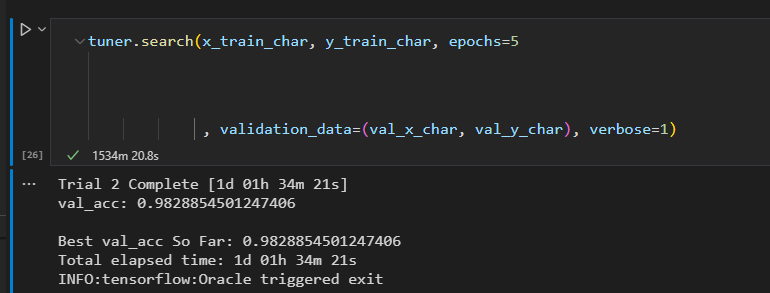

## **Get the best model**

In [56]:
# Get the optimal hyperparameters and save the model #

# model_search = tuner.get_best_models(num_models=2)
# best_model = model_search[0]
# best_model.save('hypertuned_model')

### Load the hypertuned model ###
hyper_model  = load_model('hypertuned_model')
hyper_model.summary()

Model: "hyperParam_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 32)            5728      
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 80)            12880     
                                                                 
 time_distributed (TimeDistr  (None, 17, 25)           2025      
 ibuted)                                                         
                                                                 
 gruLayer (GRU)              (None, 32)                5664      
                                                                 
 dense_1Layer (Dense)        (None, 80)                2640      
                                                  

## **Model Prediction**

# **TODO#11**
Write code that call model.fit, or model.fit_generator if you have data      
generator, to train you models. Make sure you have validation_data as an     
argument and use verbose=2 to generate one log line per epoch. Select your   
batch size carefully as it will affect your model's ability to converge and  
time needed for one epoch.                                                   
                                                                             
Hint: Read about callbacks_list argument on the documentation. You might     
find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     
process. Feel free to use any other callback function available.             

In [57]:
y_hyper_pred = model_evaluate(x_test_char, y_test, hyper_model, classreport=True)

70998/70998 [==============================] - 209s 3ms/step
              precision    recall  f1-score   support

           0     0.9916    0.9875    0.9895   1638887
           1     0.9679    0.9785    0.9731    633045

    accuracy                         0.9850   2271932
   macro avg     0.9798    0.9830    0.9813   2271932
weighted avg     0.9850    0.9850    0.9850   2271932



In [58]:
evaluate(x_test_char, y_test, hyper_model)

70998/70998 [==============================] - 223s 3ms/step


(0.973145747906553, 0.9678768701902418, 0.9784723044965208)

From this section we manage to get the best model with the hyperparameter tuning. with the f1-score of 0.9731 (target > 0.97)